## Imports

In [31]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import Model
import Plots
import matplotlib.pyplot as plt
import knnClassifier
from sklearn.utils.extmath import softmax
import plot_confusion_matrix as plots

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Hyperparameters

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $D$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [2]:
l = 0.1
mu = 0.5
K = 3
D = 4
L = np.eye(D, dtype=float)
alpha = 0.001

## Functions

This block defines two functions that we will use to compute the distances. The first function calculates the distance given two points xi and xj. The second function calculates the distance between some point xi and all the other points X, through the L space. This is very important to note. 

In [3]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1 / 2 * np.nansum(np.square(xi - xj) / (xi + xj))

def distance(xi, X):
    """
    Chi square distance from one point xi, to all other points
    
    :param xi: Embedding       (1, D)
    :param X: Data             (N, D)
    :return: Distances         (1, N)
    
    """
    N, K = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances

These next functions are calculating the target neighbors and the imposters. Read through the comments, and it should make sense how it is done. One little note: In the target neighbours function, we find the distance through the L space. This is meant as the initial L space. We only find these target neighbours once, and should therefore not update what target neighbors a specific point xi has. 

In [4]:
def find_target_neighbors(X, Y):
    """
    Find target neighbours for all points
    
    :param X: Data Matrix      (N, D)
    :param Y: Labels           (1, N)
    :return: TN_lookup_table   (N, K)
    :return: TN_distance_table (N, K)
    """
    
    global TN_lookup_table
    global TN_distance_table
    
    N, _ = np.shape(X)
    TN_lookup_table = np.zeros((N, K))
    TN_distance_table = np.zeros((N, K))

    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        
        # Find distance from xi to all other points
        TN_Distances = distance(xi, X)
        TN_Indicies = np.argsort(TN_Distances)
        j = k = 0
        
        #Loop to add indicies of target neighbours to lookup table
        while j < K:
            # if yi and target neighbour have the same label AND it is not the same point
            if Y[TN_Indicies[k]] == yi and TN_Indicies[k] != i:
                # Add to lookup table and distance table
                TN_lookup_table[i, j] = TN_Indicies[k]
                TN_distance_table[i, j] = TN_Distances[TN_Indicies[k]]
                j += 1
            k += 1
    TN_lookup_table = TN_lookup_table.astype(int)
    return TN_lookup_table, TN_distance_table


def find_imposters(i, X, Y):
    """
    Find imposters for a given point in index i
    
    :param i: Index in data matrix 
    :param X: Data Matrix    (N, D)
    :param Y: Labels         (1, N)
    :return: imposters       (?, D)
    :return: imposters_dist  (1, D)
    """
    
    #Max margin = max distance of a target neighbour for that point + l
    max_dist = 0
    for TN in TN_lookup_table[i,:]:
        
        # We need to update the distance to our target neighbours and compute the max distance
        dist = chi_square_distance(L @ X[i], L @ X[TN])
        if dist > max_dist:
            max_dist = dist
    
    #Max dist + margin l
    max_margin = max_dist + l
    
    #Find distances 
    distances = distance(X[i,:], X)
    imposters = np.array([0])
    for j, index in enumerate(np.argsort(distances)):
        if distances[j] > max_margin:
            break
        elif Y[i] != Y[index]:
            imposters = np.append(imposters, index)
    imposters.astype(int)
    return imposters[1:]

### LMNN Functions

These next functions, are made from looking at this [Paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf). Specifically, if you scroll to the last page you can see the equations that are implemented below. Here are some notes, that helps when you read it: 
* $L_{\alpha, \beta}$ refers to the alpha'th row and the beta'th column in the L matrix. Same goes for all the other places there is subscript. 
* $\psi_{i, j, \alpha}$ in this paper is the same as $t_{i,j}$ in the Yang paper
* In this paper they refer to imposters with the letter l (as opposed to k in the other papers)
* $\xi_{i, j, l}$ I interpret as a check that the point $x_{l}$ is actually an imposter. That should always be the case since, we calculate the imposters this way in the imposters function. However, that doesn't always hold for some reason. <b>We need to figure out why that is!</b> 

In [5]:
# Tau Function
def tau_function(X_Matrix, L_Matrix, i, j, alpha):
    N, D = np.shape(X_Matrix)
    numerator = 0
    denominator = 0
    for k in range(D):
        numerator +=   L_Matrix[alpha, k] * (X_Matrix[i, k] - X_Matrix[j, k])
        denominator += L_Matrix[alpha, k] * (X_Matrix[i, k] + X_Matrix[j, k])
    return numerator / denominator

In [6]:
### PULL FUNCTIONS
def Pull(X_Matrix, L_Matrix):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta)
    return gradient_matrix

def Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta):
    N, D = np.shape(X_Matrix)
    elem = 0
    for i in range(N):
        for j in TN_lookup_table[i, :]:
            tau = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            elem += 2 * tau * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tau**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
    return elem

In [7]:
### PUSH FUNCTIONS
def Push(X_Matrix, L_Matrix, Y):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta)
    return gradient_matrix


def check(L_matrix, xi, xj, xk):
    return chi_square_distance(L @ xi, L @ xj) + l >= chi_square_distance(L @ xi, L @ xk)


def Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta):
    N, D = np.shape(X_Matrix)
    elem = 0
    for i in range(N):
        xi = X_Matrix[i,:]
        imposters = find_imposters(i, X_Matrix, Y)
        for j in TN_lookup_table[i, :]:
            for l_imposter in imposters:
                if check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[l_imposter]):
                    tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
                    tauik = tau_function(X_Matrix, L_Matrix, i, l_imposter, alpha)
                    Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta])          - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[l_imposter, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[l_imposter, beta])
                    elem += Lij - Lik
                else:
                    print(i, j, l_imposter)
    return elem


In [8]:
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L)

## Dataset - IRIS

In [50]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, random_state=0)

# Normalize data
X_train = X_train / np.sum(X_train, axis = 1)[:,None]
X_test = X_test / np.sum(X_test, axis = 1)[:,None]

In [51]:
l = 0.1
mu = 0.5
K = 3
_, D = np.shape(X_train)
L = np.eye(D, dtype=float)
alpha = 0.001

In [52]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train)

## Dataset - Digits

In [12]:
l = 0.1
mu = 0.5
K = 3
D = 10
L = np.eye(D, dtype=float)
alpha = 0.001

In [13]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=0)

# Reduce dimensions 
pca = sk_decomp.PCA(n_components=D)
pca.fit(X_train)
X_train = abs(pca.transform(X_train))
X_train = X_train / np.sum(X_train, axis = 1)[:,None]
print(sum(pca.explained_variance_ratio_))

0.742655791235381


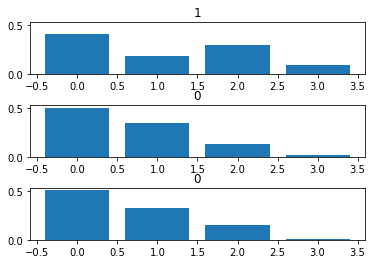

In [20]:
new_X = (L @ X_train.T).T

plot_items = new_X[20:101:40,:]
plot_labels = y_train[20:101:40]
Plots.plot_some_data(plot_items, plot_labels)

In [15]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train)

## Run

In [53]:
ITERATIONS = 10

for i in range(ITERATIONS):
    print(i)
    Gt = (1 - mu) * Pull(X_train, L) + mu * Push(X_train, L, y_train)
    update_step(Gt)
    #print(Gt)
    print(L)
    print("\n")

0
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
11 86 99
11 14 99
[[0.48647563 0.18391015 0.16114913 0.16846509]
 [0.16939635 0.5366554  0.13421518 0.15973306]
 [0.12053094 0.12230554 0.56101952 0.196144  ]
 [0.0751609  0.08939023 0.21553301 0.61991586]]


1
[[0.34719326 0.27768579 0.17529422 0.19982673]
 [0.25006342 0.46824499 0.11648915 0.16520243]
 [0.09106908 0.08209581 0.53567857 0.29115654]
 [0.05901943 0.05628104 0.40708301 0.47761651]]


2
[[0.30289846 0.30786911 0.1802268  0.20900563]
 [0.27577259 0.43365863 0.12019851 0.17037028]
 [0.05968998 0.05458846 0.55341572 0.33230585]
 [0.0357543  0.03494062 0.50809502 0.42121005]]


3
[[0.28932945 0.31768956 0.18151876 0.21146223]
 [0.28504457 0.4120424  0.12716615 0.17574688]
 [0.03585526 0.03465496 0.57577145 0.

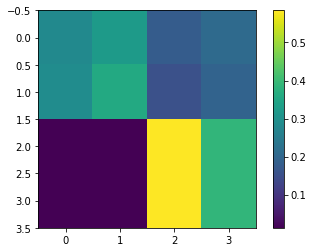

In [54]:
Plots.plot_kernel(L)

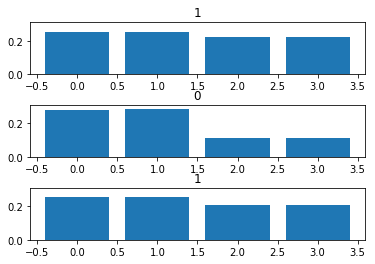

In [55]:
new_X = (L @ X_train.T).T

plot_items = new_X[20:101:40,:]
plot_labels = y_train[20:101:40]
Plots.plot_some_data(plot_items, plot_labels)

## Testing

Confusion matrix, without normalization
[[3 0 0]
 [8 0 0]
 [4 0 0]]


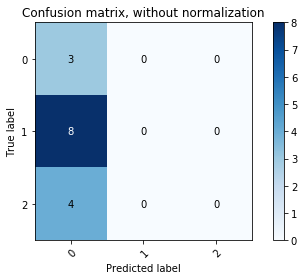

In [65]:
prediction = []

for i in range(len(X_test)):
    prediction.append(knnClassifier.knn(X_test[i], X_train, y_train, L, 5))

prediction
confusion_matrix = plots.plot_confusion_matrix(y_test, prediction, normalize=False)